# Ares Demo

Example on running Ares.

## Imports

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch

from ares import utils

Fontconfig warning: ignoring UTF-8: not a valid region tag


## Config File

For this demo, we'll use a direct dictionary rather than loading a JSON file.

In [5]:
# config = utils.get_config('/path/to/config.json')

config = {
    'attacker': {
        'attack_type': 'evasion',
        'attack_name': 'ProjectedGradientDescent',
        'attack_params': {
            'norm': 'inf',
            'eps': 0.03137254901,
            'eps_step': 0.00784313725,
            'num_random_init': 0,
            'max_iter': 1,
            'targeted': False,
            'batch_size': 1,
            'verbose': False
        }
    },
    'defender': {
        'probabilities': [0.3, 0.7],
        'models': [
            {
                'model_file': '../models/resnet.py',
                'model_name': 'resnet18_nat',
                'model_params': {
                    'num_classes': 10
                },
                'model_state': '../ares/state_dicts/resnet18_nat.pth',
                'classifier_type': 'PyTorchClassifier',
                'classifier_params': {
                    'loss': 'torch.nn.CrossEntropyLoss',
                    'input_shape': [3, 32, 32],
                    'nb_classes': 10,
                    'clip_values': [0, 1]
                }
            },
            {
                'model_file': '../models/resnet.py',
                'model_name': 'resnet18_adv',
                'model_params': {
                    'num_classes': 10
                },
                'model_state': '../ares/state_dicts/resnet18_adv.pth',
                'classifier_type': 'PyTorchClassifier',
                'classifier_params': {
                    'loss': 'torch.nn.CrossEntropyLoss',
                    'input_shape': [3, 32, 32],
                    'nb_classes': 10,
                    'clip_values': [0, 1]
                }
            }
        ]
    },
    'scenario': {
        'threat_model': 'white_box',
        'num_agents': 2,
        'reward': 0,
        'dataroot': '../downloads',
        'random_noise': True,
        'num_episodes': 50,
        'num_trials': 50
    }
}

## Environment

Create the attacker, defender, and scenario first. Then initialize the Gym environment using the three components.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create components
defender_agent = utils.get_defender_agent(config, device)
attacker_agent = utils.get_attacker_agent(config)
execution_scenario = utils.get_execution_scenario(config)
# create environment
env = gym.make('AresEnv-v0', attacker=attacker_agent, defender=defender_agent, scenario=execution_scenario)

Files already downloaded and verified


## Run Experiment

Run the simulation for the number of trials specified in the execution scenario. Record the number of rounds until the attacker wins for each trial.

In [7]:
counts = []
for trial in range(execution_scenario.num_trials):
    print(f'=== Trial {trial + 1} ===')

    # initialize environment
    observation = env.reset()
    image = observation['image']
    label = observation['label']
    done = False
    print(f'True label: {label[0]}')
    print('Preds: ', end='')

    # run simulation
    while not done:
        action = {
            'image': image,
            'label': label,
        }
        observation, reward, done, info = env.step(action)
        image = observation['image_adv']
        pred = observation['pred']
        winner = observation['winner']
        episode = info['step_count']

        print(f'{pred[0]}, ', end='')

    print(f'\nGame end: {winner} wins after {episode} rounds')
    counts.append(episode)

=== Trial 1 ===
True label: 7
Preds: 7, 7, 2, 
Game end: attacker wins after 3 rounds
=== Trial 2 ===
True label: 4
Preds: 4, 9, 
Game end: attacker wins after 2 rounds
=== Trial 3 ===
True label: 3
Preds: 3, 3, 3, 3, 3, 3, 5, 
Game end: attacker wins after 7 rounds
=== Trial 4 ===
True label: 7
Preds: 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 
Game end: attacker wins after 10 rounds
=== Trial 5 ===
True label: 2
Preds: 0, 
Game end: attacker wins after 1 rounds
=== Trial 6 ===
True label: 0
Preds: 0, 8, 
Game end: attacker wins after 2 rounds
=== Trial 7 ===
True label: 5
Preds: 5, 3, 
Game end: attacker wins after 2 rounds
=== Trial 8 ===
True label: 1
Preds: 1, 1, 3, 
Game end: attacker wins after 3 rounds
=== Trial 9 ===
True label: 7
Preds: 7, 4, 
Game end: attacker wins after 2 rounds
=== Trial 10 ===
True label: 3
Preds: 5, 
Game end: attacker wins after 1 rounds
=== Trial 11 ===
True label: 8
Preds: 8, 8, 8, 8, 8, 8, 8, 8, 3, 
Game end: attacker wins after 9 rounds
=== Trial 12 ===
True la

## Statistics

Statistics and visualizations for the experiment.

[3, 2, 7, 10, 1, 2, 2, 3, 2, 1, 9, 2, 7, 2, 2, 3, 6, 11, 4, 1, 14, 12, 3, 6, 2, 1, 2, 16, 3, 9, 9, 6, 3, 2, 6, 3, 5, 1, 2, 1, 1, 2, 1, 2, 2, 1, 4, 1, 8, 7]
min: 1, max: 16
mean: 4.3, stddev: 3.678, median: 3.0


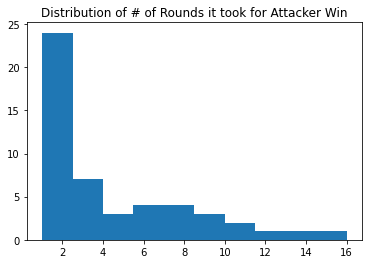

In [10]:
print(counts)
print(f'min: {np.min(counts)}, max: {np.max(counts)}')
print(f'mean: {np.mean(counts)}, stddev: {np.std(counts):.3f}, median: {np.median(counts)}')

plt.hist(counts)
plt.title("Distribution of # of Rounds it took for Attacker Win")
plt.show()